In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from bokeh.palettes import Spectral8
from bokeh.models import ColumnDataSource, Whisker, LabelSet
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Viridis3
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from scipy.stats import kruskal
output_notebook()

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_student_activity.tsv', sep='\t', on_bad_lines='skip')
data_sorted = data.dropna(subset=['teacher_user_id', 'school_year', 'script_id', 'student_user_id']).sort_values(by=['teacher_user_id', 'school_year'])

Loading BokehJS ...

# 5.1 Analysis of Teacher Platform Implementation

This section gives a detailed view of teachers' engagement and implementation of instructional activities in code.org. Through this analysis, we aimed to segment teachers based on their levels of platform implementation, which was gauged through metrics like the number of unique scripts they assigned and the number of students they taught. The resulted cluster membership could denote how actively teachers are involved with the platform, both in terms of the variety (unique scripts) and reach (unique students).

## Teacher Implementation Clusters

this {code}`compute_cumulative_unique` function calculate

- The cumulative number of unique scripts assigned up to and including that school year.

- The cumulative number of unique students taught up to and including that school year.

In [2]:
cumulative_data = data_sorted.groupby(['teacher_user_id', 'school_year']).agg({
    'script_id': 'unique',
    'student_user_id': 'unique'
}).reset_index()

# Define a function to compute cumulative unique values for a series
def compute_cumulative_unique(series):
    cumulative_list = []
    seen = set()
    for s in series:
        seen.update(s)
        cumulative_list.append(len(seen))
    return cumulative_list

# Apply the function to get cumulative unique scripts and students for each teacher
cumulative_data['cumulative_scripts'] = cumulative_data.groupby('teacher_user_id')['script_id'].transform(compute_cumulative_unique)
cumulative_data['cumulative_students'] = cumulative_data.groupby('teacher_user_id')['student_user_id'].transform(compute_cumulative_unique)

# Drop the temporary columns
cumulative_data = cumulative_data.drop(columns=['script_id', 'student_user_id'])


Before applying clustering, we need to apply the Elbow method to find the optimal number of clusters.

The Elbow method is used to determine the optimal number of clusters by fitting the model with a range of cluster values and then plotting the resulting within-cluster sum of squares (WCSS) against the number of clusters.

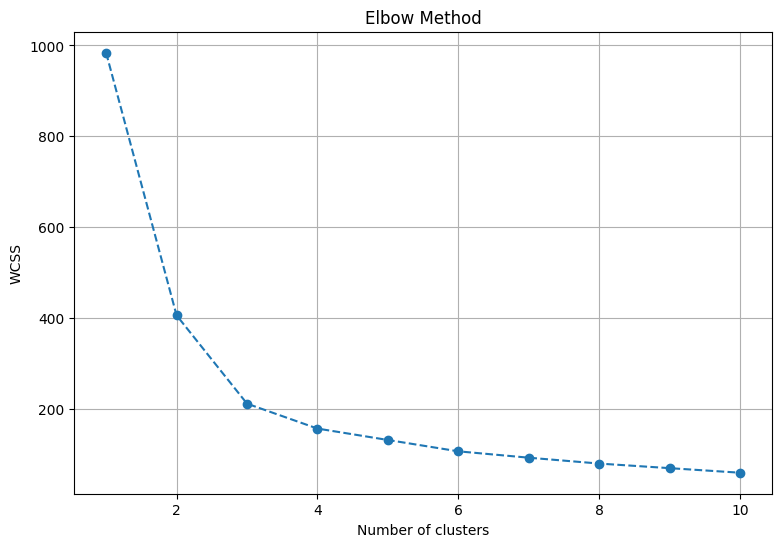

In [3]:
# Scaling the cumulative metrics
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cumulative_data[['cumulative_scripts', 'cumulative_students']])

# Applying the Elbow method
wcss = []
cluster_range = range(1, 11)

for i in cluster_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(9, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


It's based on the point where the rate of decrease of the WCSS starts to slow down, indicating diminishing returns in terms of the tightness of clusters. 

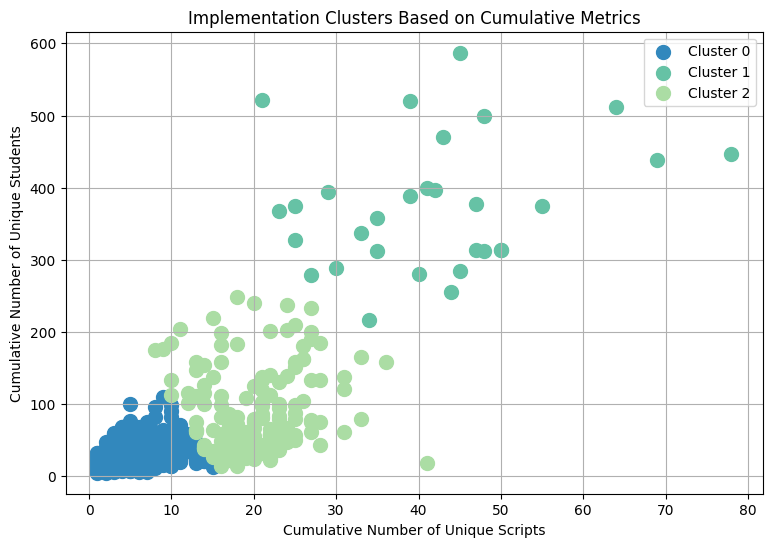

In [4]:
# Applying KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
cumulative_data['cluster'] = kmeans.fit_predict(scaled_data)

plt.figure(figsize=(9, 6))

colors = Spectral8[0:3]
for cluster, color in zip(range(3), colors):
    subset = cumulative_data[cumulative_data['cluster'] == cluster]
    plt.scatter(subset['cumulative_scripts'], subset['cumulative_students'], s=100, c=color, label=f'Cluster {cluster}')

plt.title('Implementation Clusters Based on Cumulative Metrics')
plt.xlabel('Cumulative Number of Unique Scripts')
plt.ylabel('Cumulative Number of Unique Students')
plt.legend()
plt.grid(True)
plt.show()

Teachers were segmented into three distinct clusters:

**Low Implementation**: Teachers who, up to a certain year, had assigned fewer unique scripts and engaged with fewer unique students cumulatively.

**Medium Implementation**: Teachers who had a moderate cumulative count of unique script assignments and student engagements up to that year.

**High Implementation**: The most active teachers who, cumulatively, assigned a large number of unique scripts and reached many unique students up to that year.

## Kruskal-Wallis H-test Results

For each implementation metric , a Kruskal-Wallis H-test was conducted to test for statistical differences between implementation clusters. 

In [5]:
cumulative_data['cluster_str'] = cumulative_data['cluster'].astype(str)
implementation_labels = { '0': 'Low Implementation', '2': 'Medium Implementation', '1': 'High Implementation'}
cumulative_data['cluster_str'] = cumulative_data['cluster_str'].map(implementation_labels)
clusters = ['Low Implementation', 'Medium Implementation', 'High Implementation']

plots = []
for aspect in ['cumulative_scripts', 'cumulative_students']:
    # Calculate the Kruskal-Wallis test results
    groups = [group[aspect].dropna() for name, group in cumulative_data.groupby('cluster_str')]
    H_result, p_result = kruskal(*groups)  

    # Calculate the eta-squared statistic (effect size)
    n = sum(len(group) for group in groups)
    eta_squared = H_result / (n - 1)

    # Compute quantiles
    qs = cumulative_data.groupby('cluster_str')[aspect].quantile([0.25, 0.5, 0.75])
    qs = qs.unstack().reset_index()
    qs.columns = ['cluster_str', 'q1', 'q2', 'q3']
    df = pd.merge(cumulative_data, qs, on='cluster_str', how='left')

    # Compute IQR outlier bounds
    iqr = df.q3 - df.q1
    df['upper'] = df.q3 + 1.5*iqr
    df['lower'] = df.q1 - 1.5*iqr

    source = ColumnDataSource(df)

    p = figure(x_range=clusters, y_range=(0, cumulative_data[aspect].max()*1.1), width=380, height=450, y_axis_label=f'{aspect} by cluster', tools="", toolbar_location=None, title=f"Distribution of {aspect} by cluster")

    # quantile boxes
    cmap = factor_cmap('cluster_str', palette=Spectral8[0:3], factors=clusters)
    p.vbar('cluster_str', 0.7, 'q2', 'q3', source=source, color=cmap, line_color='black')
    p.vbar('cluster_str', 0.7, 'q1', 'q2', source=source, color=cmap, line_color='black')

    # outliers
    whisker = Whisker(base='cluster_str', upper='upper', lower='lower', source=source)
    whisker.upper_head.size = whisker.lower_head.size = 6
    p.add_layout(whisker)
    outliers = df[~df[aspect].between(df.lower, df.upper)]
    p.circle('cluster_str', aspect, source=outliers, size=6, color='black', alpha=0.3)

    p.xgrid.grid_line_color = None
    p.axis.major_label_text_font_size="10px"
    p.axis.axis_label_text_font_size="9px"

    source = ColumnDataSource(data=dict(
        x=['Low Implementation'],
        y=[cumulative_data[aspect].max() * 1.05], 
        text=[f"Kruskal-Wallis H = {H_result:.2f}, p = {p_result:.2f}, η² = {eta_squared:.2f}"],
    ))
    labels = LabelSet(x='x', y='y', text='text', level='glyph',
                      x_offset=-15, y_offset=-5, source=source, text_font_size="10pt")
    p.add_layout(labels)

    plots.append(p)

At the top of each plot, the results of the Kruskal-Wallis H-test are displayed. This test is a non-parametric method used to determine if there are statistically significant differences between two or more groups. The p-value gives the probability that the differences observed could have occurred by random chance. The η2 value is the effect size, which quantifies the magnitude of the observed effect.

In [6]:
grid = gridplot([plots])
show(grid, notebook_handle=True);

* The {code}`cumulative unique number of scripts ` and {code}`cumulative unique number of students` metrics showed clear distinctions between the three Implementation clusters. This indicates that teachers' cumulative implementation with the platform can be effectively gauged by considering how many unique scripts they've assigned and how many unique students they've reached over the years.

* The **High Implementation cluster**, cumulatively, not only assigns more unique scripts but also reaches a broader unique student audience up to that year. These teachers seem to be consistently using the platform across school years and integrating it deeply into their curricula.

* The statistical tests confirmed that the Implementation differences between the clusters are indeed significant.